In [14]:
%config IPCompleter.greedy=True

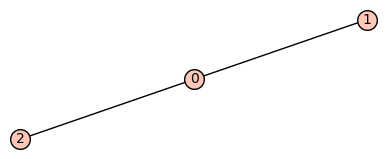

In [18]:
#g = graphs.CycleGraph(4)
g = Graph(3) #Graph({0: [1], 1: [2,3], 3: [4,5]})
g.add_edge(0,1)
g.add_edge(0,2)
#d = g.to_directed()
#list(g.breadth_first_search(0))
#g.vertices()[0]
show(g)
treenumbers = [0] * g.order()
levelordernumbers = [0] * g.order()
visited = [False] * g.order()
disjointsets = [0] * g.order()
trees = list()



In [19]:
m = Matroid(g)
m.basis

<built-in method basis of GraphicMatroid object at 0x7fb852de0600>

In [86]:
def find(data, i):
    if i != data[i]:
        data[i] = find(data, data[i])
    return data[i]

def union(data, i, j):
    pi, pj = find(data, i), find(data, j)
    if pi != pj:
        data[pi] = pj

In [87]:
iterator = m.bases()
for i in iterator:
    print(i)

frozenset([(0, 1), (0, 2)])


In [88]:
from queue import *

def rootTree(self, root, treenumber):
    d = DiGraph()
    q = Queue()
    q.put(root)
    levelordernumber = 0
    
    while not q.empty():
        v = q.get()
        levelordernumber += 1
        levelordernumbers[v] = levelordernumber
        visited[v] = True
        treenumbers[v] = treenumber
        neighborIterator = self.neighbor_iterator(v)
        for n in neighborIterator:
            if not visited[n]:
                d.add_edge(v,n)
                q.put(n)
                
    return d
        
Graph.rootTree = rootTree

In [89]:
def c((a,b)):
    if treenumbers[a] != treenumbers[b]:
        return None
    
    cycle = list()
    tree = trees[treenumbers[a]]
    
    while levelordernumbers[a] != levelordernumbers[b]:
        if levelordernumbers[a] > levelordernumbers[b]:
            parent = tree.neighbors_in(a)[0]
            if find(disjointsets, parent) != find(disjointsets, a):
                cycle.append((parent, a))
                union(disjointsets, parent, a)
            a = parent
        else:
            parent = tree.neighbors_in(b)[0]
            if find(disjointsets, parent) != find(disjointsets, b):
                cycle.append((parent, b))
                union(disjointsets, parent, b)
            b = parent
    
    
    show(tree)
    return cycle

In [90]:
def start():
    global disjointsets
    disjointsets = [i for i in range(g.order())]
    components = g.connected_components_subgraphs()
    for idx, c in enumerate(components):
        trees.append(c.rootTree(c.vertices()[0], idx))

In [91]:
start()
levelordernumbers
#treenumbers

[1, 2, 3]

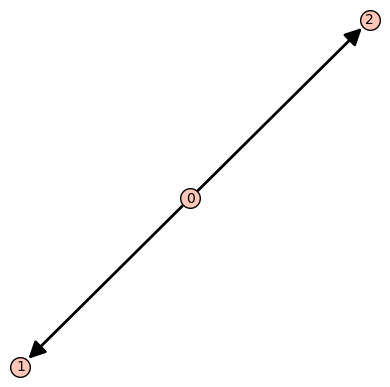

[]

In [93]:
c((1,2))